In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from time import time

Opening Data...

In [2]:
PATH = "D:/Program Files (x86)/Jupyter Projects/"
filepath = PATH + "Electric_Production.csv"
df = pd.read_csv(filepath)
df

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


Preprocessing...

In [3]:
df.columns = ['Date','Consumption']

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df = df.set_index(df['Date'])

In [6]:
df.drop(columns=['Date'],inplace=True)

Plotting the Time Series...

In [7]:
import plotly.express as px

fig = px.line(df,x=df.index, y='Consumption', title='Electricity Consumed (1985-2017)')
fig.update_layout(
    xaxis=dict(
                rangeselector = dict(
                    buttons = list([
                dict(count=1,label ="1y", step="year",stepmode="backward"),
                dict(count=2,label ="2y", step="year",stepmode="backward"),
                dict(count=3,label ="3y", step="year",stepmode="backward"),
                dict(count=4,label ="4y", step="year",stepmode="backward"),
                  ])
                ),
                rangeslider=dict(
            visible=True
        ),
    ))

Seasonality and Trend are visually apparent

Creating Train-Test splits...

In [8]:
train = df[:'2015']
test = df['2016':]

Removing Trend....

In [9]:
df_copy = train.copy()

df_copy = df_copy.diff()

df_copy

,Consumption
Date,
1985-01-01,NaN
1985-02-01,-1.8332
1985-03-01,-8.2218
1985-04-01,-4.9788
1985-05-01,-2.1563
...,...
2015-08-01,-1.0429
2015-09-01,-8.6721
2015-10-01,-10.3245


<AxesSubplot:xlabel='Date'>

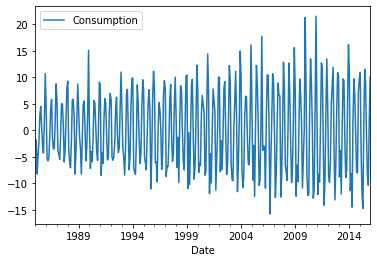

In [10]:
df_copy.plot()

Volatility possibly present?

Removing Seasonality...

In [11]:
df_monthly_avgs = df_copy.groupby(df_copy.index.month).mean()
df_monthly_avgs

,Consumption
Date,
1,6.942463
2,-6.808900
3,-6.277384
4,-8.730119
5,0.132129
6,7.763790
7,7.353371
8,0.311910
9,-8.501681


In [12]:
df_copy['Monthly Avg'] = df_copy.index.map(lambda x: df_monthly_avgs.loc[x.month,'Consumption'])
df_copy

,Consumption,Monthly Avg
Date,,
1985-01-01,NaN,6.942463
1985-02-01,-1.8332,-6.808900
1985-03-01,-8.2218,-6.277384
1985-04-01,-4.9788,-8.730119
1985-05-01,-2.1563,0.132129
...,...,...
2015-08-01,-1.0429,0.311910
2015-09-01,-8.6721,-8.501681
2015-10-01,-10.3245,-6.155006


In [13]:
df_copy['Consumption'] = df_copy['Consumption'] - df_copy['Monthly Avg']
df_copy

,Consumption,Monthly Avg
Date,,
1985-01-01,NaN,6.942463
1985-02-01,4.975700,-6.808900
1985-03-01,-1.944416,-6.277384
1985-04-01,3.751319,-8.730119
1985-05-01,-2.288429,0.132129
...,...,...
2015-08-01,-1.354810,0.311910
2015-09-01,-0.170419,-8.501681
2015-10-01,-4.169494,-6.155006


<AxesSubplot:xlabel='Date'>

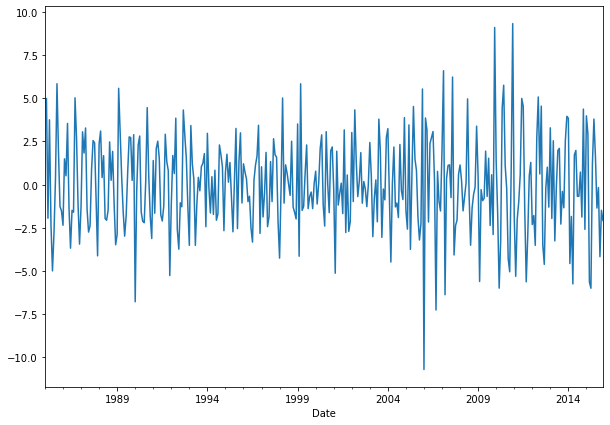

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
df_copy['Consumption'].plot()

Trying ADF Test...

In [15]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df_copy['Consumption'].dropna())
print("p-value of Electric Consumption (modified) 1985-2017: {}".format(float(adf[1])))

p-value of Electric Consumption (modified) 1985-2017: 2.8421213060071756e-09


Plotting PACF for AR (p) and ACF for MA (q)....

d:\Anaconda\envs\geoenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



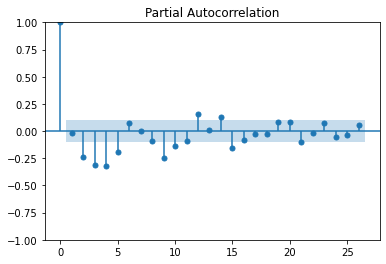

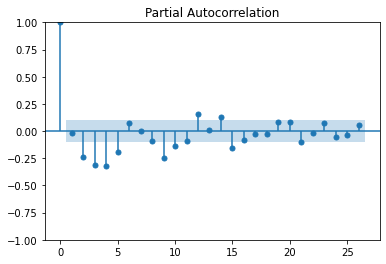

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df_copy['Consumption'].dropna())

So, AR(12) but limiting to AR(4) 

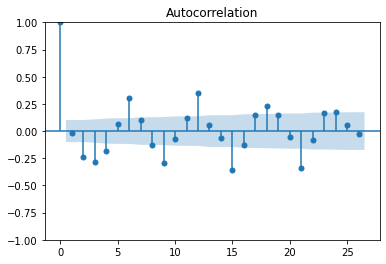

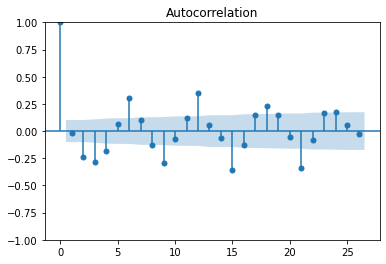

In [17]:
plot_acf(df_copy['Consumption'].dropna())

So, MA(21) but limiting to MA(3)

p = 4, d = 1, q = 3

Using these values, formulating SARIMAX model....

In [29]:
# import pmdarima as pm

# model = pm.auto_arima(train, m = 12, seasonal = True, start_p = 0, 
#                       start_q = 0, max_p=9, max_q=11, start_P=0, max_P=12, start_Q=20, max_Q=21, max_d=1, max_D=1, test = 'adf', 
#                       error_action = 'ignore', suppress_warnings = True,
#                       stepwise = True, trace = True)


In [47]:
# import itertools

# p = range(0,13)
# d = range(0,2)
# q = range(0,22)

# pdq = list(itertools.product(p, d, q))

# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# import statsmodels.api as sm
# import warnings

# warnings.filterwarnings("ignore")
# AIC = []
# SARIMAX_model = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(train,
#                                             order=param,
#                                             seasonal_order=param_seasonal)

#             results = mod.fit()

#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue

In [ ]:
# print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

In [18]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

mod = sm.tsa.statespace.SARIMAX(train, order=(4,1,3), seasonal_order=(4,1,3,12))
results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  372
Model:             SARIMAX(4, 1, 3)x(4, 1, 3, 12)   Log Likelihood                -801.138
Date:                            Tue, 14 Jun 2022   AIC                           1632.276
Time:                                    19:07:52   BIC                           1690.526
Sample:                                01-01-1985   HQIC                          1655.439
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8011      0.356     -2.251      0.024      -1.498      -0.104
ar.L2         -0.0474      0.214     -0.222      0.824      -0.466       0.371
ar.L3          0.3237      0.169      1.916      0.055      -0.007       0.655
ar.L4          0.0094      0.082      0.114      0.909      -0.152       0.171
ma.L1          0.4213      0.360      1.171      0.242      -0.284       1.126
ma.L2         -0.5910      0.206     -2.864      0.004      -0.995      -0.187
ma.L3         -0.6830      0.315     -2.171      0.030      -1.299      -0.067
ar.S.L12      -0.4212      1.348     -0.313      0.755      -3.062       2.220
ar.S.L24      -0.4067      1.289     -0.315      0.752      -2.934       2.121
ar.S.L36      -0.1495      0.293     -0.511      0.610      -0.723       0.424
ar.S.L48      -0.0854      0.240     -0.356      0.722      -0.556       0.385
ma.S.L12      -0.2218      1.352     -0.164      0.870      -2.871       2.428
ma.S.L24      -0.0587      1.647     -0.036      0.972      -3.287       3.169
ma.S.L36      -0.0823      0.851     -0.097      0.923      -1.749       1.585
sigma2         4.9137      0.349     14.096      0.000       4.230       5.597
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.34
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

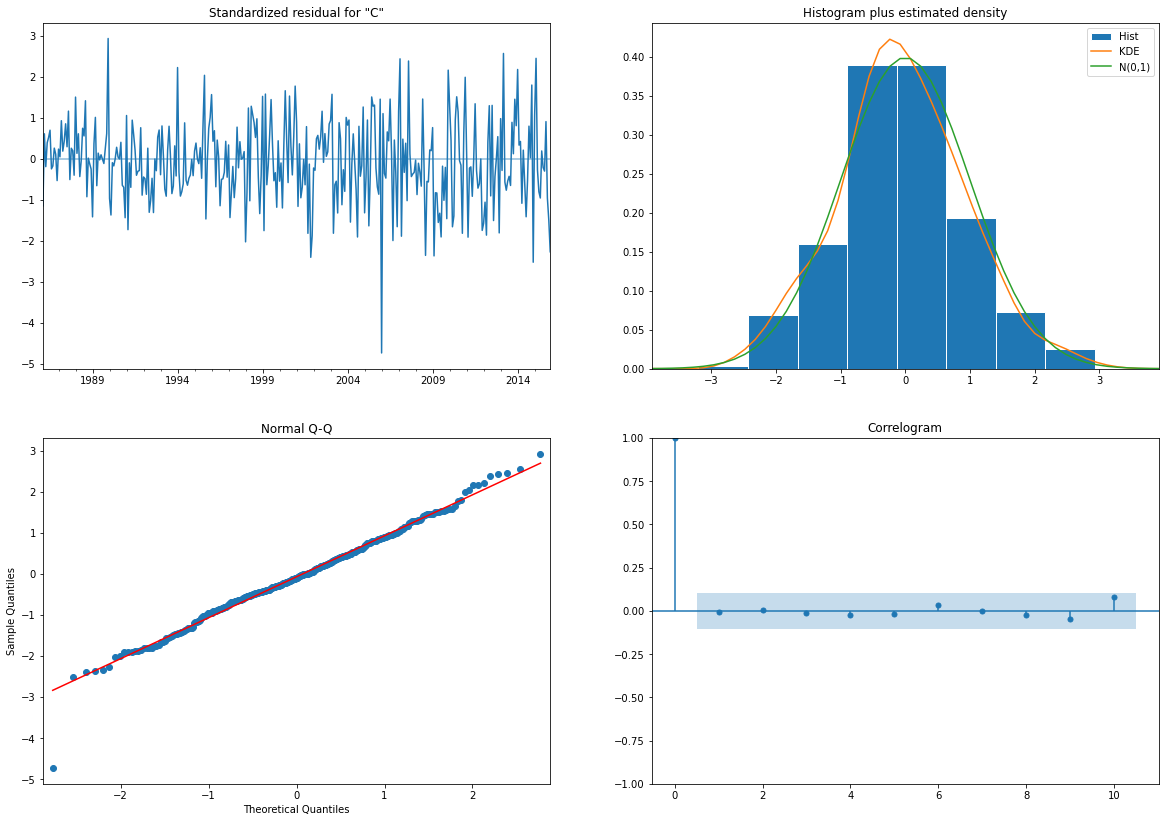

In [19]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

Testing different Forecasts...

In [20]:
pred0 = results.get_prediction(start='2016-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [21]:
pred1 = results.get_prediction(start='2016-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [22]:
pred2 = results.get_forecast('2019-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2016-01-01':'2016-12-01'])

2016-01-01    115.102007
2016-02-01    109.381207
2016-03-01    101.241622
2016-04-01     89.746308
2016-05-01     91.738862
2016-06-01    102.579603
2016-07-01    112.271858
2016-08-01    111.031261
2016-09-01    100.542869
2016-10-01     91.903466
2016-11-01     95.091514
2016-12-01    108.175450
Freq: MS, Name: predicted_mean, dtype: float64


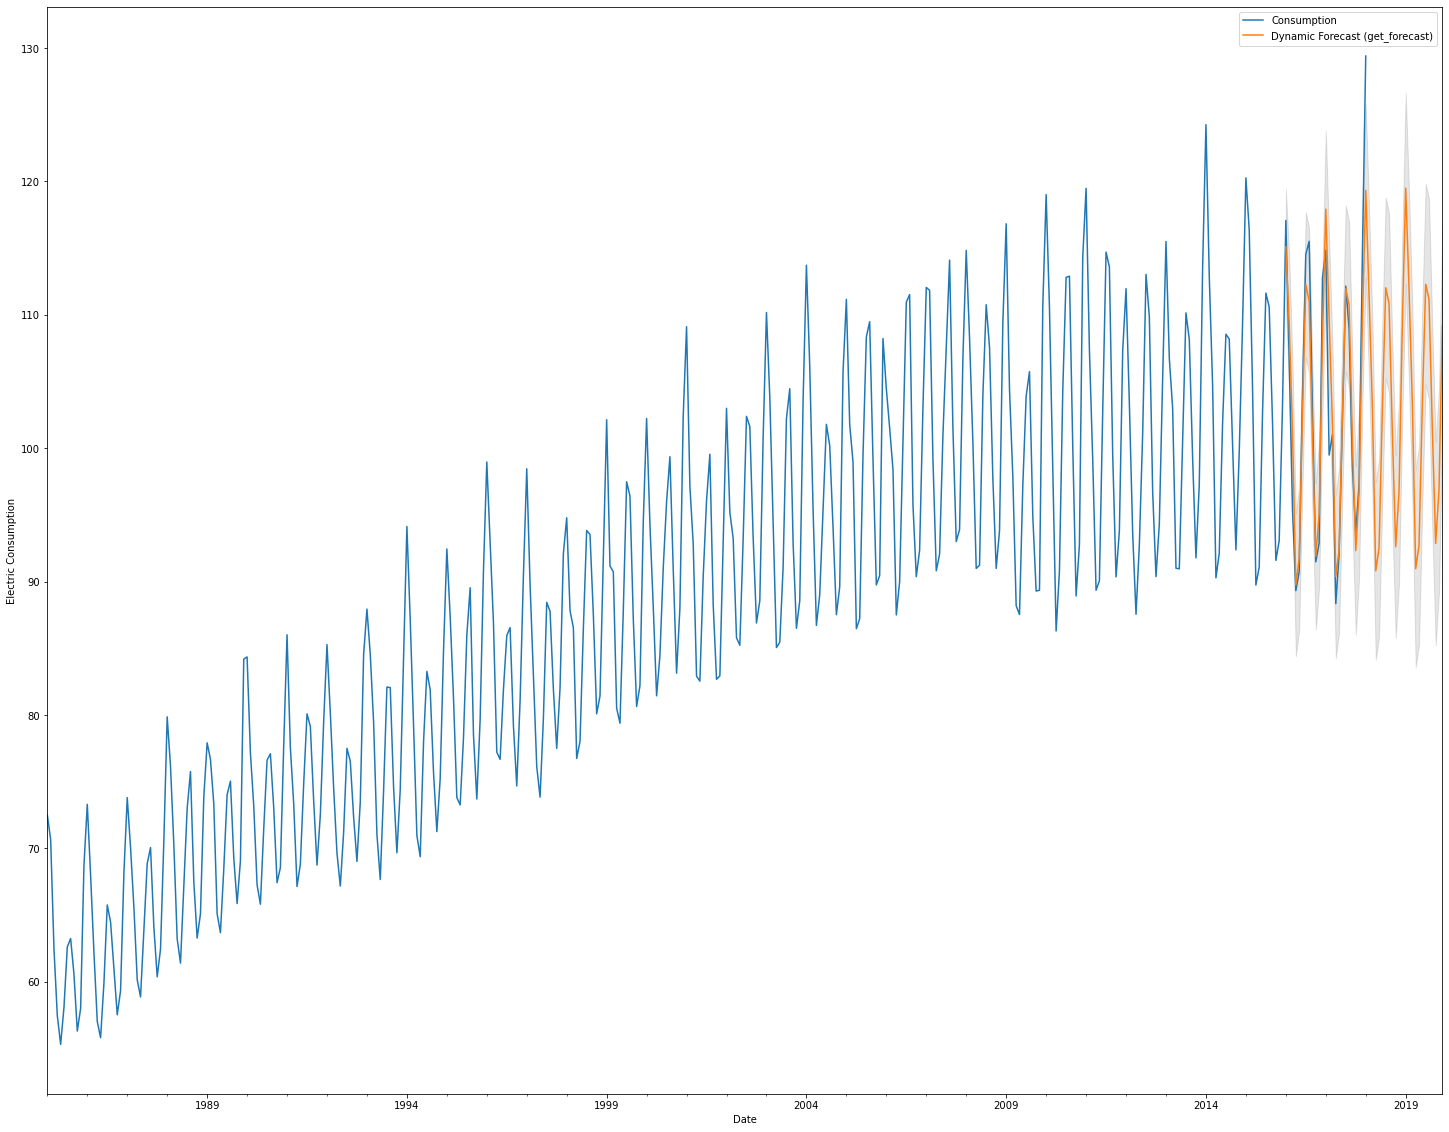

In [23]:
ax = df.plot(figsize=(25, 20))
# pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
# pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Electric Consumption')
plt.xlabel('Date')
plt.legend()
plt.show()

Checking Test Data vs Forecast...

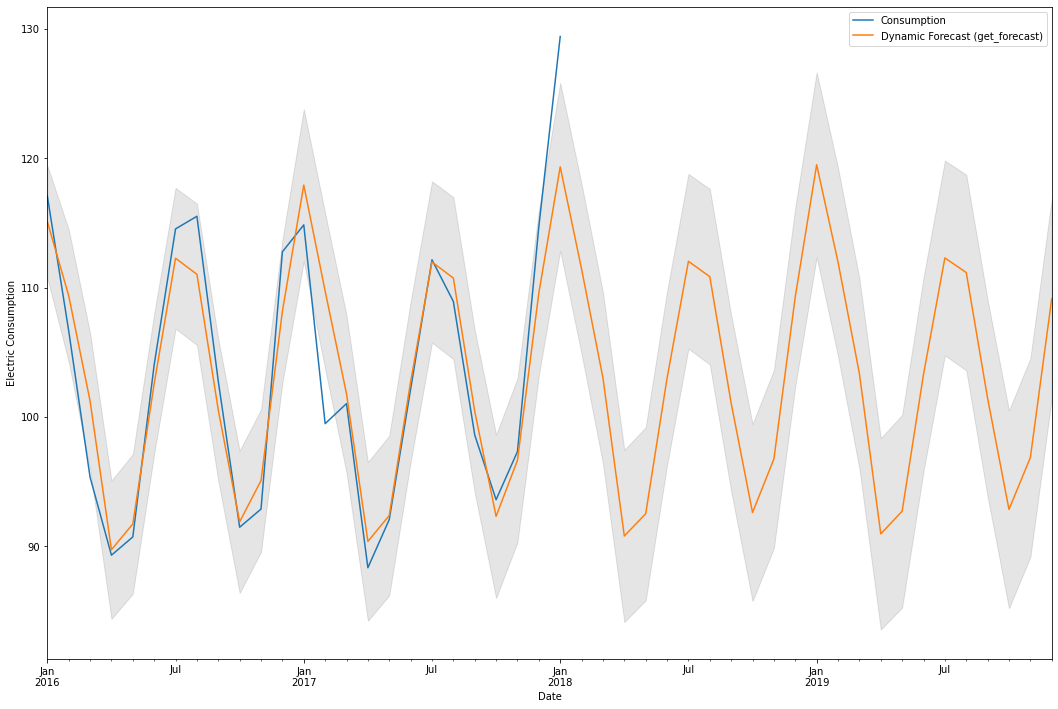

In [24]:
ax = test.plot(figsize=(18,12))
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Electric Consumption')
plt.xlabel('Date')
plt.legend()
plt.show()

Checking RMSE...

In [ ]:
prediction = pd.DataFrame(pred2.predicted_mean['2016-01-01':'2018-01-01'])

In [33]:
prediction.columns = ['Consumption']

In [34]:
residuals = test - prediction
residuals

,Consumption
Date,
2016-01-01,1.981693
2016-02-01,-2.712407
2016-03-01,-5.886822
2016-04-01,-0.420908
2016-05-01,-1.001962
2016-06-01,1.457897
2016-07-01,2.267842
2016-08-01,4.484639
2016-09-01,2.220831


In [36]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: Consumption    3.803282
dtype: float64
